In [1]:
import sys
import os

sys.path.append('scripts')

import re
import json
import argparse
import itertools
from pathlib import Path
import collections
from dataclasses import dataclass,asdict, astuple
from concurrent.futures import ProcessPoolExecutor

import numpy as np
import matplotlib.pyplot as plt
# from matplotlib.font_manager import FontProperties
import matplotlib.font_manager as fm
from matplotlib.patches import FancyBboxPatch
from matplotlib.patches import PathPatch
from matplotlib.path import get_path_collection_extents
from matplotlib.colors import LinearSegmentedColormap, LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

from rich import print, pretty
from typing import  Iterable
import pretty_errors
from catppuccin import PALETTE

from utils import *
from ldj import ldj

pretty.install()

RESULT_DIR: Path = Path("../experiments/iteration-amount")

assert RESULT_DIR.is_dir() and RESULT_DIR.exists()


flavor = PALETTE.latte.colors
# num-robots-10-seed-0.json
RE = re.compile(r"internal-(\d+)-external-(\d+)-seed-(\d+).json")


sys.executable = '/home/kpbaks/.nix-profile/bin/python'

sys.version = '3.11.9 (main, Apr  2 2024, 08:25:04) [GCC 13.2.0]'

In [2]:
# use LaTeX for text with matplotlib
sns.set_style("darkgrid")
# set background color of sns darkgrid to flavor.base.hex
plt.rcParams['axes.facecolor'] = flavor.base.hex
# set font color to flavor.text.hex
plt.rcParams['text.color'] = flavor.text.hex

font_dirs = ["./fonts/"]
# go through all fonts in the font directory and add them
for font_dir in font_dirs:
    for font in os.listdir(font_dir):
        fm.fontManager.addfont(f"{font_dir}/{font}")

prop_jbm = fm.FontProperties(fname='./fonts/JetBrainsMonoNerdFontMono-Regular.ttf')
prop = fm.FontProperties(fname='./fonts/STIXTwoText-VariableFont_wght.ttf')

plt.rcParams.update({
    # "text.usetex": True,
    "font.family": prop.get_name(),
    # "font.family": "stix",
    # "font.sans-serif": prop.get_name(),
    "mathtext.fontset": "stix",
    # "text.latex.preamble": r"\usepackage{fontenc}\usepackage{fontspec}\setmainfont{JetBrainsMonoNerdFontMono-Regular}",
})

print(prop.get_name())

colors = [
    (flavor.lavender.hex, 1.0, (1, 0), 'o'),
    (flavor.yellow.hex, 0.3, (2, 2), 'X'),
    (flavor.peach.hex, 0.3, (2, 2), 'X'),
    (flavor.green.hex, 1.0, (2, 2), '^')
]

STIX Two Text

In [3]:

def flatten(lst: Iterable) -> list:
    return list(itertools.chain.from_iterable(lst))


@dataclass(frozen=True)
class ExperimentParams:
    internal: int
    external: int
    seed: int

@dataclass
class ProcessedData:
    distance_travelled: list[float]
    finished_at: list[float]
    ldj: list[float]
    makespan: float
    robot_collisions: int
    params: ExperimentParams


def process_file(file) -> ProcessedData:
    match = RE.match(file.name)
    assert match is not None
    internal = int(match.group(1))
    external = int(match.group(2))
    seed = int(match.group(3))

    with open(file, 'r') as file:
        data = json.load(file)

    distance_travelled_of_each_robot: list[float] = []
    finished_at_of_each_robot: list[float] = []
    ldj_of_each_robot: list[float] = []
    robot_collisions: int = len(data['collisions']['robots'])
    environment_collisions: int = len(data['collisions']['environment'])

    for _, robot_data in data['robots'].items():
        positions = np.array(robot_data['positions'])
        distance_travelled: float = np.sum(np.linalg.norm(np.diff(positions, axis=0), axis=1))
        distance_travelled_of_each_robot.append(distance_travelled)

        mission = robot_data['mission']
        # robot_collisions += robot_data['collisions']['robots']

        started_at: float = mission['started_at']
        finished_at: float = mission['finished_at'] if mission['finished_at'] else mission['duration'] + started_at
        finished_at_of_each_robot.append(finished_at)

        timestamps: np.ndarray = np.array([measurement['timestamp'] for measurement in robot_data['velocities']])
        velocities3d_bevy: np.ndarray = np.array([measurement['velocity'] for measurement in robot_data['velocities']])
        velocities = velocities3d_bevy[:, [0, 2]]

        ldj_metric = ldj(velocities, timestamps)
        ldj_of_each_robot.append(ldj_metric)

    makespan: float = data['makespan']

    params = ExperimentParams(
        internal=internal,
        external=external,
        seed=seed
    )

    return ProcessedData(
        distance_travelled=distance_travelled_of_each_robot,
        finished_at=finished_at_of_each_robot,
        ldj=ldj_of_each_robot,
        robot_collisions=robot_collisions,
        makespan=makespan,
        params=params
    )


In [4]:
processed_data: list[ProcessedData] = []
with ProcessPoolExecutor() as executor:
    results = executor.map(process_file, RESULT_DIR.glob('*.json'))

aggregated_data: dict[tuple[int, int], ProcessedData] = {}
for data in results:
    key = (data.params.internal, data.params.external)
    if key in aggregated_data:
        aggregated_data[key].distance_travelled.extend(data.distance_travelled)
        if np.max(data.finished_at) < 100:
            aggregated_data[key].finished_at.extend(data.finished_at)
        else:
            print(f"{np.max(data.finished_at)=} {key=}")
        aggregated_data[key].ldj.extend(data.ldj)
        # aggregated_data[key].ldj.extend(data.ldj)
        current = aggregated_data[key].robot_collisions
        aggregated_data[key].robot_collisions = (current + data.robot_collisions) / 2
        current = aggregated_data[key].makespan
        aggregated_data[key].makespan = (current + data.makespan) / 2
    else:
        aggregated_data[key] = data


processed_data = aggregated_data.values()


np.max(data.finished_at)=102.1 key=(1, 13)

In [5]:
# def as_grid_index(internal: int, external: int) -> (int, int):
#     assert internal % 5 == 0
#     assert external % 5 == 0
#     return (int(internal / 5) - 1, int(external / 5) - 1)


def minmax(arr: np.ndarray) -> (float, float):
    return (np.min(arr), np.max(arr))


internals = set((it.params.internal for it in processed_data))
externals = set((it.params.external for it in processed_data))
nrows: int = len(internals)
ncols: int = len(externals)


# nrows: int = max((int(it.params.internal / 5) for it in processed_data))
# ncols: int = max((int(it.params.external / 5) for it in processed_data))

extent: ((int, int), (int, int)) = (minmax([it.params.internal for it in processed_data]), minmax([it.params.external for it in processed_data]))
extent: list[int] = [*extent[0], *extent[1]]

xticks = np.array(sorted(internals))
yticks = np.array(sorted(externals))
# xticks = np.arange(5, 35, 5)
# yticks = np.arange(5, 35, 5)
x, y = np.meshgrid(xticks, yticks)

xtick_labels = [str(tick) for tick in xticks]
ytick_labels = [str(tick) for tick in yticks]

def as_grid_index(params: ExperimentParams) -> (int, int):
    x = np.where(xticks == params.internal)[0][0]
    y = np.where(yticks == params.external)[0][0]
    return (x, y)
    # return (int(params.internal / 5) - 1, int(params.external / 5) - 1)

print(f"{extent=} {nrows=} {ncols=}")
print(f"{xticks=}")
print(f"{yticks=}")

extent=[1, 34, 1, 34] nrows=8 ncols=8

xticks=array([ 1,  2,  3,  5,  8, 13, 21, 34])

yticks=array([ 1,  2,  3,  5,  8, 13, 21, 34])

In [6]:
params = ExperimentParams(internal=8, external=2, seed=0)
print(f"{as_grid_index(params)=}")

as_grid_index(params)=(4, 1)

In [10]:
distance_travelled_avg_im: np.ndarray = np.zeros((nrows, ncols))
distance_travelled_median_im: np.ndarray = np.zeros((nrows, ncols))
ldj_im: np.ndarray = np.zeros((nrows, ncols))
makespan_im: np.ndarray = np.zeros((nrows, ncols), dtype=np.float64)
maximum_task_completion_time_difference_im = np.zeros((nrows, ncols))
robot_collisions_im = np.zeros((nrows, ncols), dtype=np.int32)

for it in processed_data:
    x, y = as_grid_index(it.params)
    # print(f"{it.distance_travelled.shape=}")
    # if x == 6 and y == 0:
        # print(f"{it.distance_travelled=}")
        
    distance_travelled_avg: float = np.mean(np.sort(it.distance_travelled)[:-1])
    distance_travelled_median: float = np.median(np.sort(it.distance_travelled)[:-1])
    # print(f"{it.params.internal=} {it.params.external=} {x=} {y=} {distance_travelled_avg=}")
    # print(f"{x=}, {y=} = {distance_travelled_avg=}")
    distance_travelled_avg_im[x, y] = distance_travelled_avg
    distance_travelled_median_im[x, y] = distance_travelled_median
    ldj_avg: float = np.mean(np.sort(it.ldj)[:-1])
    ldj_im[x, y] = ldj_avg

    t_min, t_max = minmax(np.sort(it.finished_at))
    t_min, t_max = minmax(np.sort(it.finished_at))
    t_diff = t_max - t_min
    if t_diff > 100:
        print(f"{it.finished_at=}")
        print(f"{it.params=}")
        print(f"{it.makespan=}")
        stop = int(len(it.finished_at) / 2)
        t_min, t_max = minmax(np.sort(it.finished_at)[0:stop])
        t_diff = t_max - t_min
        print(f"{t_diff=}")

    maximum_task_completion_time_difference_im[x, y] = t_diff
    robot_collisions_im[x, y] = it.robot_collisions
    makespan_im[x, y] = it.makespan
    # if x == 4 and y == 1:
    #     print(f"{distance_travelled_avg=}")
    


it.finished_at=[231.9, 236.2, 234.2, 218.8, 227.4, 235.5, 229.5, 236.5, 225.2, 229.8, 233.6, 234.4, 230.6, 235.9, 
235.5, 227.6, 226.5, 227.3, 234.0, 233.9, 235.7, 224.0, 227.5, 227.6, 233.0, 24.1, 27.9, 28.8, 34.9, 24.1, 30.0, 
29.3, 26.8, 21.9, 28.8, 21.6, 29.3, 30.1, 30.3, 35.0, 28.0, 25.1, 23.1, 34.0, 29.3, 31.4, 30.7, 31.0, 24.3, 22.1]

it.params=ExperimentParams(internal=13, external=1, seed=0)

it.makespan=33.01803112030029

t_diff=13.399999999999999

In [12]:
print(f"{maximum_task_completion_time_difference_im=}")
# print(f"{distance_travelled_avg_im[6,0]=}")

# print(f"{maximum_task_completion_time_difference_im=}")

# distance_travelled_avg_im[0, 0] = 5000.0
# distance_travelled_avg_im[1, 0] = 5000.0
# distance_travelled_avg_im[0, 1] = 5000.0
# distance_travelled_avg_im[-1, -1] = 3000.0


maximum_task_completion_time_difference_im=array([[35.9, 22.2, 21.8, 21.5, 34.1, 35.1, 42. , 42.6],
       [15.7, 11.7, 24.3, 18. , 14.2, 15.1, 22.3, 28.9],
       [15.5, 17.4, 23.6, 13.2, 16. , 11.4, 20.4, 15. ],
       [16.7, 16.6, 11.3, 10.5, 17. , 11.5,  9.6, 10.6],
       [20.3, 13.5,  9. ,  9. , 11.9,  9. , 13.3, 15.7],
       [13.4,  9.4, 14.3,  6.9,  8.4,  9.7, 10.4,  8.5],
       [21.3, 12. ,  8.6,  7.5,  7.8,  8.9,  8.4,  9.8],
       [13.2, 10.9,  9.2, 10.9,  8.6, 11.4,  8.9, 10.6]])

image[6, 0]=116.05462795674353 image[0,0]=216.80088265039262 image[-1, -1]=108.05752734087528

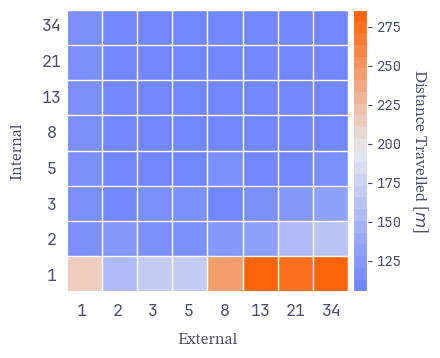

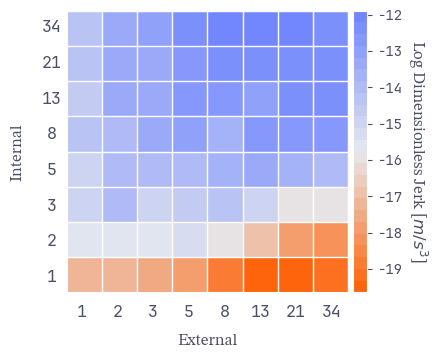

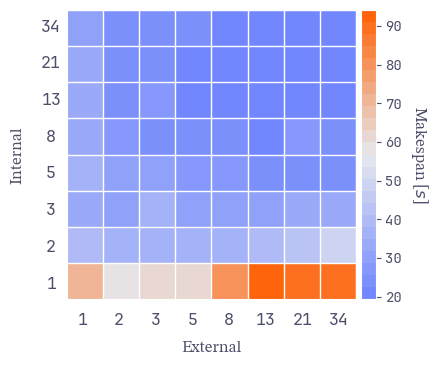

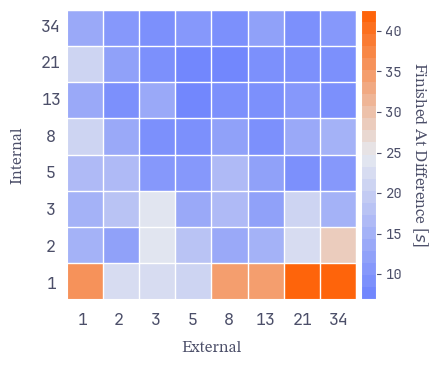

In [65]:


nplots = 3

# print(f"{distance_travelled_avg_im.shape=}")
# print(f"{nrows=} {ncols=}")

cmap_name = 'gray_to_red'
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, [flavor.peach.hex, flavor.mantle.hex, flavor.lavender.hex], N=32)

# x, y = np.meshgrid(xticks, yticks)
# hist2d_args = dict(
#     x=x.flatten(),
#     y=y.flatten(),
#     bins=[nrows, ncols],
#     # cmap='viridis'
#     # cmap=custom_cmap,
# )

figsize = (5, 5)
ax_set_args = dict(
    # xlabel='External',
    # ylabel='Internal',
    # yticks=yticks,
    # xticks=xticks,
    
    # yticklabels=(yticks, fontproperties=prop_jbm, fontdict=dict(color=flavor.text.hex))
)

# names = ['Average Distance Travelled', 'Average LDJ', 'Average Makespan']
names = ['average-distance-travelled', 'average-ldj', 'average-makespan', 'largest-time-differense']
units = ["Distance Travelled [$m$]", "Log Dimensionless Jerk [$m/s^3$]", "Makespan [$s$]", 'Finished At Difference [$s$]']
# ims = [distance_travelled_median_im, ldj_im, makespan_im, maximum_task_completion_time_difference_im]
ims = [distance_travelled_avg_im, ldj_im, makespan_im, maximum_task_completion_time_difference_im]
colors = [flavor.red.hex, flavor.green.hex, flavor.blue.hex]

cmap_name = "my_cmap"
color_good = flavor.sapphire.hex
color_good = flavor.lavender.hex
# color_good = flavor.teal.hex
color_bad  = flavor.peach.hex
color_middle = flavor.mantle.hex

colors = [color_good, flavor.mantle.hex, color_bad]
cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=32)
cmaps = [
    LinearSegmentedColormap.from_list(name, colors, N=24)
    for name, colors in zip(["foo", "bar", "baz", "karl"], [
        [color_good, color_middle, color_bad],
        [color_bad, color_middle, color_good],
        [color_good, color_middle, color_bad],
        [color_good, color_middle, color_bad],
        

        # [flavor.peach.hex, flavor.mantle.hex, flavor.lavender.hex],
        # [flavor.maroon.hex, flavor.mantle.hex, flavor.sapphire.hex],
        # [flavor.flamingo.hex, flavor.mantle.hex, flavor.sky.hex]
    ])
]

for name, unit, image, cmap in zip(names, units, ims, cmaps):
    # fig, ax = plt.subplots(figsize=figsize)
    fig, ax = plt.subplots(figsize=(4.5, 4.5))
    # hist = ax.hist2d(weights=image.flatten(), **hist2d_args, cmap=cmap, norm=LogNorm())
    if name == 'average-distance-travelled':
        print(f"{image[6, 0]=} {image[0,0]=} {image[-1, -1]=}")

# x, y = np.meshgrid(xticks, yticks)
# hist2d_args = dict(
#     x=x.flatten(),
#     y=y.flatten(),
#     bins=[nrows, ncols],
#     # cmap='viridis'
#     # cmap=custom_cmap,
# )
    cell_width = 4
    r = np.arange(cell_width, 9 * cell_width, cell_width)
    x, y = np.meshgrid(r, r)
    # print(f"{xticks=}, {yticsks=}")
    hist = ax.hist2d(x=x.flatten(), y=y.flatten(), bins=[nrows, ncols], weights=image.flatten(), cmap=cmap, norm="linear")
    # ax.set_title(name, fontsize=12, fontproperties=prop_jbm, fontdict={'color': flavor.text.hex})
    ax.set(**ax_set_args)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("External", fontsize=12, labelpad=30, fontproperties=prop, fontdict=dict(color=flavor.text.hex))
    ax.set_ylabel("Internal", fontsize=12, labelpad=30, fontproperties=prop, fontdict=dict(color=flavor.text.hex))
    ax.axis('square')
    # ax.grid(True)

    # Create a divider for existing axes instance
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    # Create colorbar
    cbar = plt.colorbar(hist[3], cax=cax)
    cbar.ax.tick_params(labelsize=10, color=flavor.text.hex)
    cbar.set_label(unit, rotation=270, labelpad=20, fontsize=12, fontproperties=prop, fontdict=dict(color=flavor.text.hex))
    tick_labels = cbar.ax.get_yticklabels()
    plt.setp(tick_labels, fontsize=10, fontweight='bold', color=flavor.text.hex, fontproperties=prop_jbm)


    # cbar = plt.colorbar(hist[3], ax=ax)
    # # cbar = plt.colorbar(hist[3], ax=ax, fraction=0.046, pad=0.025)  # Adjust fraction and pad to move the colorbar closer
    # cbar.ax.tick_params(labelsize=10, color=flavor.text.hex)  # Customize colorbar ticks
    # cbar.set_label(unit, rotation=270, labelpad=20, fontsize=12, fontproperties=prop, fontdict=dict(color=flavor.text.hex))  # Add label
    # # cbar.ax.tick_params(labelsize=12, labelcolor='red', direction='in', length=10, width=2)
    # tick_labels = cbar.ax.get_yticklabels()
    # plt.setp(tick_labels, fontsize=10, fontweight='bold', color=flavor.text.hex, fontproperties=prop_jbm)
    # # ax.text(0, 0, 'Text at (5, 5)', color='red', fontsize=12, ha='center', va='center')


    initial_width_offset = 5.5
    width = 3.55
    cursor = initial_width_offset
    for xtick in xticks:
        ax.text(cursor, 2, str(xtick), color=flavor.text.hex, fontproperties=prop_jbm, fontsize=12, ha='center', va='center')
        cursor += width

    initial_height_offset = 2.8
    height = 3.55
    cursor = initial_width_offset
    for ytick in yticks:
        ax.text(2.5, cursor, str(ytick), color=flavor.text.hex, fontproperties=prop_jbm, fontsize=12, ha='center', va='center')
        cursor += width

    # ax.hlines(y=7.5,xmin=0, xmax=50, linewidth=2, color='white')
    # ax.hlines(y=11,xmin=0, xmax=50, linewidth=2, color='white')
    # ax.hlines(y=14.5,xmin=0, xmax=50, linewidth=2, color='white')
    for i in range(ncols):
        ax.hlines(y=7.5 + i * 3.5,xmin=0, xmax=50, linewidth=1, color='white')
        ax.vlines(x=7.5 + i * 3.5,ymin=0, ymax=50, linewidth=1, color='white')
        # xs = []
        # ys = []
        # ax.hline(xs, ys)


    # ax.text(2.8, -0.5, '1', color='red', fontsize=12, ha='center', va='center')
    # ax.text(0, 1, '1', color=flavor.text.hex, fontsize=12, ha='center', va='center')

    
    fig.tight_layout()
    output = Path(f"iteration-amount-{name}.svg")
    fig.savefig(output)

plt.show()

x=array([[ 5, 10, 15, 20, 25, 30],
       [ 5, 10, 15, 20, 25, 30],
       [ 5, 10, 15, 20, 25, 30],
       [ 5, 10, 15, 20, 25, 30],
       [ 5, 10, 15, 20, 25, 30],
       [ 5, 10, 15, 20, 25, 30]])

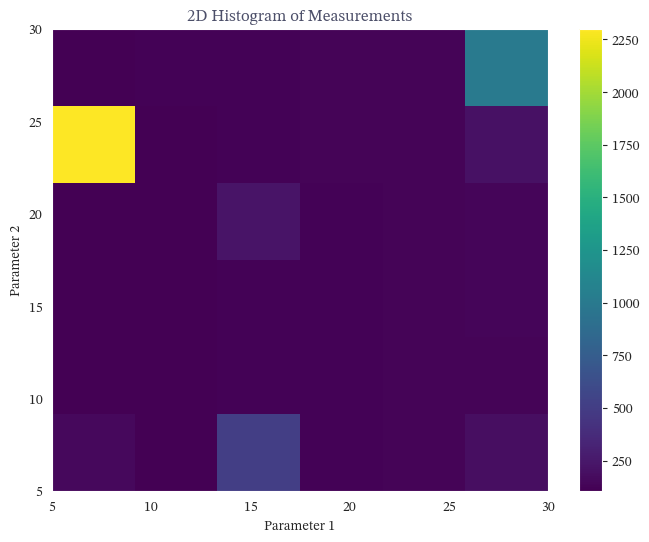

In [40]:
data = np.array([
    [155.5, 110.1, 505.2, 120.3, 125.4, 190.5],
    [106.6, 111.2, 116.3, 121.4, 126.5, 131.6],
    [107.7, 112.3, 117.4, 122.5, 127.6, 132.7],
    [108.8, 113.4, 218.5, 123.6, 128.7, 133.8],
    [2299.9, 114.5, 119.6, 124.7, 129.8, 204.9],
    [111.0, 115.6, 120.7, 125.8, 130.9, 1000.0]
])

# Generate x and y coordinates for the data points
x = np.arange(5, 35, 5)
y = np.arange(5, 35, 5)
x, y = np.meshgrid(x, y)


fig, ax = plt.subplots(figsize=(8, 6))

# Create the 2D histogram
hist = ax.hist2d(x.flatten(), y.flatten(), bins=[6, 6], weights=data.flatten(), cmap='viridis')

# Add color bar
plt.colorbar(hist[3], ax=ax)

# Set axis labels
ax.set_xlabel('Parameter 1')
ax.set_ylabel('Parameter 2')
ax.set_title('2D Histogram of Measurements')

# Customize grid lines color
ax.grid(which='both', color='gray', linestyle='-', linewidth=2)

plt.show()

In [41]:
x = [1, 2, 3, 5, 8, 13, 21, 34]
y = [1, 2, 3, 5, 8, 13, 21, 34]
# print(f"{x=}")
x, y = np.meshgrid(x, y)

x


array([[ 1,  2,  3,  5,  8, 13, 21, 34],
       [ 1,  2,  3,  5,  8, 13, 21, 34],
       [ 1,  2,  3,  5,  8, 13, 21, 34],
       [ 1,  2,  3,  5,  8, 13, 21, 34],
       [ 1,  2,  3,  5,  8, 13, 21, 34],
       [ 1,  2,  3,  5,  8, 13, 21, 34],
       [ 1,  2,  3,  5,  8, 13, 21, 34],
       [ 1,  2,  3,  5,  8, 13, 21, 34]])

In [47]:
# Sample data
data = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 100])

# Calculate the first quartile (Q1) and the third quartile (Q3)
Q1 = np.percentile(data, 5)
Q3 = np.percentile(data, 95)
print(f"{Q1=}")

# Calculate the Interquartile Range (IQR)
IQR = Q3 - Q1

# Determine the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the data to remove top outliers
filtered_data = data[data <= upper_bound]

print("Original data:", data)
print("Filtered data:", filtered_data)

Q1=1.5

Original data: [  1   2   3   4   5   6   7   8   9  10 100]

Filtered data: [  1   2   3   4   5   6   7   8   9  10 100]

In [58]:

data = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 100])

data[1:-1]

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10])

In [52]:
a = np.array([1, 3, 2, 0])
np.sort(a)

array([0, 1, 2, 3])